#### Library import

In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

import re
from tqdm import tqdm

#### GPU setting

In [27]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [28]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [29]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5753639343699152511
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10577806845032008376
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [30]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [31]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [32]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [33]:
As = data
Cd = data
Ni = data

In [34]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [35]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [36]:
import smogn

In [37]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   3%|2         | 4/148 [00:00<00:08, 16.49it/s]

r_index: 100%|##########| 91/91 [00:00<00:00, 576.66it/s]


In [38]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [39]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [40]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [41]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [42]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [43]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(876, 15)
(1224, 15)
(1093, 15)


StandardScaler

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.3, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.3, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.3, random_state=42)

MinMaxScaler

In [45]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [46]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(613, 15)
(856, 15)
(765, 15)


#### 10-Fold Crossvalidation

In [47]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [48]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [49]:
from sklearn.model_selection import cross_val_score

def objectiveLGBM(trial: Trial, X_train, y_train) -> float:
    lgbm_paramas = {
        "random_state": 42,
        "learning_rate": 0.1, 
        "n_estimators": trial.suggest_int("n_estimators", 500, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 30),
        "num_leaves": trial.suggest_int("num_leaves", 2, 32),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "num_iterations": trial.suggest_int("num_iterations", 500, 1000)
    }
    
    lgbm = LGBMRegressor(**lgbm_paramas)
    r2 = cross_val_score(lgbm, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [50]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:37:31,232] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-17 22:37:35,616] Trial 0 finished with value: 0.47936288417239226 and parameters: {'n_estimators': 890, 'max_depth': 20, 'num_leaves': 24, 'min_child_samples': 3, 'num_iterations': 938}. Best is trial 0 with value: 0.47936288417239226.
[I 2023-08-17 22:37:36,905] Trial 1 finished with value: 0.46334973434042925 and parameters: {'n_estimators': 627, 'max_depth': 4, 'num_leaves': 17, 'min_child_samples': 2, 'num_iterations': 659}. Best is trial 0 with value: 0.47936288417239226.
[I 2023-08-17 22:37:38,546] Trial 2 finished with value: 0.46773266628394 and parameters: {'n_estimators': 644, 'max_depth': 28, 'num_leaves': 19, 'min_child_samples': 6, 'num_iterations': 512}. Best is trial 0 with value: 0.47936288417239226.
[I 2023-08-17 22:37:39,557] Trial 3 finished with value: 0.47673005238035754 and parameters: {'n_estimators': 911, 'max_depth': 13, 'num_leaves': 6, 'min_child_samples': 4, 'n

Best r2:  0.5148328821379986
Best trial: {'n_estimators': 584, 'max_depth': 12, 'num_leaves': 15, 'min_child_samples': 1, 'num_iterations': 811}


In [51]:
optuna.visualization.plot_parallel_coordinate(study)

In [52]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 584, 'max_depth': 12, 'num_leaves': 15, 'min_child_samples': 1, 'num_iterations': 811}


In [53]:
study.best_trial.params["n_estimators"]

584

In [54]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(As_X_train, As_y_train)

LGBMRegressor(max_depth=12, min_child_samples=1, n_estimators=584,
              num_iterations=811, num_leaves=15, random_state=42)

In [55]:
y_train_pred = lgbm.predict(As_X_train)
y_test_pred = lgbm.predict(As_X_test)

In [56]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [57]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.009657802021598456
Test RMSE:  0.32856407921279


In [58]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9996332667251405
Test R2:  0.533366896987626


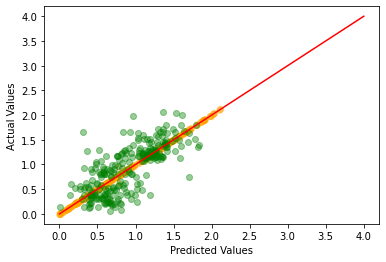

In [59]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [60]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:42:44,847] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-17 22:42:47,543] Trial 0 finished with value: 0.576719505111926 and parameters: {'n_estimators': 773, 'max_depth': 21, 'num_leaves': 11, 'min_child_samples': 8, 'num_iterations': 853}. Best is trial 0 with value: 0.576719505111926.
[I 2023-08-17 22:42:50,608] Trial 1 finished with value: 0.5645053365833193 and parameters: {'n_estimators': 665, 'max_depth': 5, 'num_leaves': 25, 'min_child_samples': 7, 'num_iterations': 900}. Best is trial 0 with value: 0.576719505111926.
[I 2023-08-17 22:42:51,390] Trial 2 finished with value: 0.5562471672229714 and parameters: {'n_estimators': 845, 'max_depth': 14, 'num_leaves': 5, 'min_child_samples': 7, 'num_iterations': 528}. Best is trial 0 with value: 0.576719505111926.
[I 2023-08-17 22:42:53,348] Trial 3 finished with value: 0.5694793961716129 and parameters: {'n_estimators': 786, 'max_depth': 30, 'num_leaves': 6, 'min_child_samples': 6, 'num_iterat

Best r2:  0.5952950711417129
Best trial: {'n_estimators': 999, 'max_depth': 21, 'num_leaves': 8, 'min_child_samples': 5, 'num_iterations': 784}


In [61]:
optuna.visualization.plot_parallel_coordinate(study)

In [62]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 999, 'max_depth': 21, 'num_leaves': 8, 'min_child_samples': 5, 'num_iterations': 784}


999

In [63]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Cd_X_train, Cd_y_train)

LGBMRegressor(max_depth=21, min_child_samples=5, n_estimators=999,
              num_iterations=784, num_leaves=8, random_state=42)

In [64]:
y_train_pred = lgbm.predict(Cd_X_train)
y_test_pred = lgbm.predict(Cd_X_test)

In [65]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.009054706694053689
Test RMSE:  0.05369525674662779


In [66]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.9890272071700869
Test R2:  0.6111657032151261


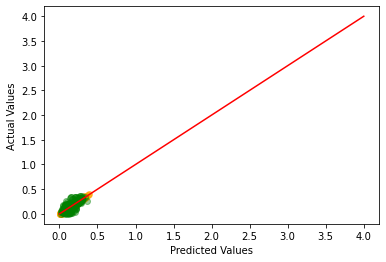

In [67]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4], [0, 4], color='red', linestyle='-')

plt.show()

Ni

In [68]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveLGBM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-17 22:46:49,853] A new study created in memory with name: lgbm_parameter_opt
[I 2023-08-17 22:46:55,367] Trial 0 finished with value: 0.7817323926767281 and parameters: {'n_estimators': 533, 'max_depth': 22, 'num_leaves': 19, 'min_child_samples': 6, 'num_iterations': 896}. Best is trial 0 with value: 0.7817323926767281.
[I 2023-08-17 22:46:57,937] Trial 1 finished with value: 0.7960930528180284 and parameters: {'n_estimators': 599, 'max_depth': 27, 'num_leaves': 8, 'min_child_samples': 5, 'num_iterations': 829}. Best is trial 1 with value: 0.7960930528180284.
[I 2023-08-17 22:46:58,839] Trial 2 finished with value: 0.7930903183248239 and parameters: {'n_estimators': 812, 'max_depth': 13, 'num_leaves': 6, 'min_child_samples': 9, 'num_iterations': 522}. Best is trial 1 with value: 0.7960930528180284.
[I 2023-08-17 22:47:06,137] Trial 3 finished with value: 0.7826539243452373 and parameters: {'n_estimators': 723, 'max_depth': 27, 'num_leaves': 30, 'min_child_samples': 4, 'num_i

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:47:17,441] Trial 7 finished with value: 0.7888169686940836 and parameters: {'n_estimators': 828, 'max_depth': 26, 'num_leaves': 31, 'min_child_samples': 10, 'num_iterations': 714}. Best is trial 1 with value: 0.7960930528180284.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-08-17 22:47:22,827] Trial 8 finished with value: 0.78746601670363 and parameters: {'n_estimators': 764, 'max_depth': 17, 'num_leaves': 31, 'min_child_samples': 7, 'num_iterations': 690}. Best is trial 1 with value: 0.7960930528180284.
[I 2023-08-17 22:47:23,433] Trial 9 finished with value: 0.7901913204040418 and parameters: {'n_estimators': 957, 'max_depth': 3, 'num_leaves': 4, 'min_child_samples': 5, 'num_iterations': 535}. Best is trial 1 with value: 0.7960930528180284.
[I 2023-08-17 22:47:25,425] Trial 10 finished with value: 0.7980805519524514 and parameters: {'n_estimators': 675, 'max_depth': 20, 'num_leaves': 11, 'min_child_samples': 1, 'num_iterations': 818}. Best is trial 10 with value: 0.7980805519524514.
[I 2023-08-17 22:47:27,094] Trial 11 finished with value: 0.7980880615669425 and parameters: {'n_estimators': 679, 'max_depth': 20, 'num_leaves': 11, 'min_child_samples': 1, 'num_iterations': 821}. Best is trial 11 with value: 0.7980880615669425.
[I 2023-08-17 22:47:

Best r2:  0.8040072378704378
Best trial: {'n_estimators': 502, 'max_depth': 18, 'num_leaves': 14, 'min_child_samples': 1, 'num_iterations': 895}


In [69]:
optuna.visualization.plot_parallel_coordinate(study)

In [70]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 502, 'max_depth': 18, 'num_leaves': 14, 'min_child_samples': 1, 'num_iterations': 895}


502

In [71]:
lgbm_params = {
    "random_state": 42,
    "learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "num_leaves": study.best_trial.params["num_leaves"],
    "min_child_samples": study.best_trial.params["min_child_samples"],
    "num_iterations": study.best_trial.params["num_iterations"]
}

lgbm = LGBMRegressor(**lgbm_params)
lgbm.fit(Ni_X_train, Ni_y_train)

LGBMRegressor(max_depth=18, min_child_samples=1, n_estimators=502,
              num_iterations=895, num_leaves=14, random_state=42)

In [72]:
y_train_pred = lgbm.predict(Ni_X_train)
y_test_pred = lgbm.predict(Ni_X_test)

In [73]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.004500418237388392
Test RMSE:  0.4590499574026822


In [74]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9999863378188206
Test R2:  0.8539091694612185


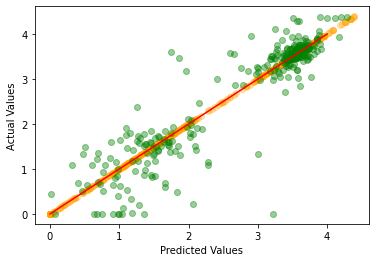

In [75]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()